In [58]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [59]:
with open('../data/raw/static_dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [60]:
df.head(1)

,gameDuration,gameCreation,gameVersion,mapId,queueId,patch,seasonId,platformId,participant1_level,participant1_tier,...,participant10_champion_kills,participant10_champion_deaths,participant10_champion_assists,participant10_champion_lp,participant10_champion_maxKills,participant10_champion_cs,participant10_champion_damage,participant10_champion_gold,participant10_teamId,participant10_win
0,1311,1696800045102,13.19.534.5972,11,420,19,13,EUW1,296,CHALLENGER,...,1.4,4.1,13.8,173.0,12.0,32.9,5895.0,6802.0,200,False


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 0
Columns: 268 entries, gameDuration to participant10_win
dtypes: bool(50), float64(58), int64(66), object(94)
memory usage: 879.9+ KB


In [62]:
import os
import sys

print(os.path.dirname(sys.executable))

/Users/admin/opt/miniconda3/envs/Leaguify/bin


In [63]:
df.describe()

,gameDuration,gameCreation,mapId,queueId,patch,seasonId,participant1_level,participant1_rank,participant1_leaguePoints,participant1_wins,...,participant10_rank,participant10_leaguePoints,participant10_wins,participant10_losses,participant10_champion_lastPlayTime,participant10_champion_championLevel,participant10_champion_championPoints,participant10_champion_championPointsSinceLastLevel,participant10_champion_tokensEarned,participant10_teamId
count,500.000000,5.000000e+02,500.0,500.0,500.00000,500.0,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,4.190000e+02,419.000000,4.190000e+02,4.190000e+02,419.000000,500.0
mean,1582.224000,1.696367e+12,11.0,420.0,18.83800,13.0,437.602000,1.124000,595.594000,175.734000,...,1.190000,620.986000,169.122000,145.190000,1.696743e+12,5.568019,3.137768e+05,2.949677e+05,0.725537,200.0
std,305.543377,4.953085e+08,0.0,0.0,0.36882,0.0,312.575492,0.511025,348.464219,109.066044,...,0.665421,365.945742,113.124345,108.507445,2.397617e+08,1.585529,5.730222e+05,5.715605e+05,1.018298,0.0
min,962.000000,1.694659e+12,11.0,420.0,18.00000,13.0,40.000000,1.000000,0.000000,2.000000,...,1.000000,0.000000,2.000000,0.000000,1.695827e+12,1.000000,1.220000e+02,1.030000e+02,0.000000,200.0
25%,1367.750000,1.696012e+12,11.0,420.0,19.00000,13.0,142.750000,1.000000,377.000000,104.000000,...,1.000000,358.000000,86.000000,58.000000,1.696652e+12,5.000000,3.244850e+04,1.084850e+04,0.000000,200.0
50%,1553.000000,1.696511e+12,11.0,420.0,19.00000,13.0,374.500000,1.000000,588.000000,157.000000,...,1.000000,647.000000,155.000000,126.500000,1.696853e+12,6.000000,1.072590e+05,8.565900e+04,0.000000,200.0
75%,1767.250000,1.696780e+12,11.0,420.0,19.00000,13.0,678.000000,1.000000,827.000000,248.000000,...,1.000000,847.000000,235.000000,205.250000,1.696896e+12,7.000000,2.997530e+05,2.781530e+05,2.000000,200.0
max,2860.000000,1.696971e+12,11.0,420.0,19.00000,13.0,1446.000000,4.000000,1585.000000,662.000000,...,4.000000,2040.000000,665.000000,641.000000,1.696975e+12,7.000000,4.115137e+06,4.093537e+06,3.000000,200.0


In [64]:
df.dtypes

gameDuration                      int64
gameCreation                      int64
gameVersion                      object
mapId                             int64
queueId                           int64
                                  ...  
participant10_champion_cs        object
participant10_champion_damage    object
participant10_champion_gold      object
participant10_teamId              int64
participant10_win                  bool
Length: 268, dtype: object

<Axes: >

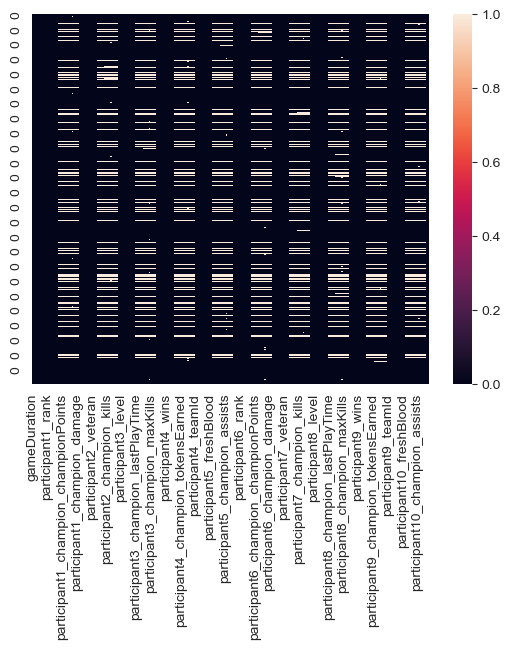

In [65]:
sns.heatmap(df.isna())

/var/folders/ww/zccj65710l313xpntj6vpnth0000gn/T/ipykernel_70675/1072140413.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

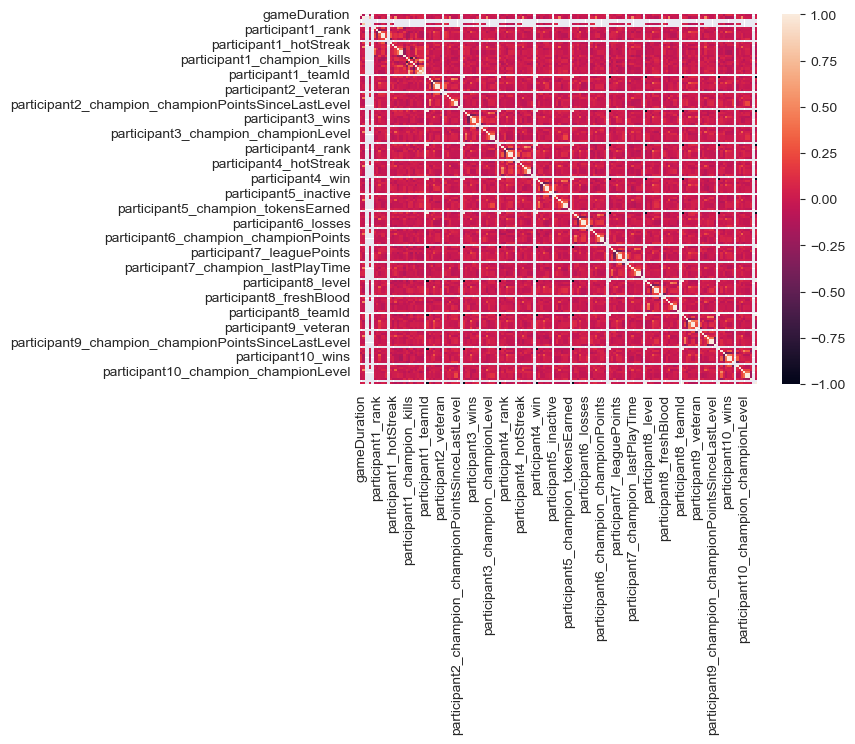

In [66]:
sns.heatmap(df.corr())

In [67]:
df.isna().sum()

gameDuration                      0
gameCreation                      0
gameVersion                       0
mapId                             0
queueId                           0
                                 ..
participant10_champion_cs        82
participant10_champion_damage    82
participant10_champion_gold      82
participant10_teamId              0
participant10_win                 0
Length: 268, dtype: int64

In [106]:
def drop_missing(df: pd.DataFrame) -> pd.DataFrame:
    len_before = len(df)
    df_new = df.dropna(axis=0)
    print(f'dropped {len_before - len(df)} rows')
    return df_new


def replace_missing(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.fillna(-1)
    return df_new

In [105]:
df = drop_missing(df)
#replace_missing(df)

dropped 0 rows


the first 5 participants are always in the same team:

In [70]:
df['participant1_win'] == df['participant2_win']

0    True
0    True
0    True
0    True
0    True
     ... 
0    True
0    True
0    True
0    True
0    True
Length: 344, dtype: bool

In [71]:
df.head()

,gameDuration,gameCreation,gameVersion,mapId,queueId,patch,seasonId,platformId,participant1_level,participant1_tier,...,participant10_champion_kills,participant10_champion_deaths,participant10_champion_assists,participant10_champion_lp,participant10_champion_maxKills,participant10_champion_cs,participant10_champion_damage,participant10_champion_gold,participant10_teamId,participant10_win
0,1311,1696800045102,13.19.534.5972,11,420,19,13,EUW1,296,CHALLENGER,...,1.4,4.1,13.8,173.0,12.0,32.9,5895.0,6802.0,200,False
0,1968,1696690505980,13.19.534.5972,11,420,19,13,EUW1,111,MASTER,...,1.4,5.3,16.6,280.0,13.0,31.0,6391.0,7453.0,200,False
0,1143,1696801609868,13.19.534.5972,11,420,19,13,EUW1,570,MASTER,...,1.3,6.4,13.6,201.0,14.0,30.4,5819.0,6953.0,200,True
0,1633,1696504407176,13.19.534.5972,11,420,19,13,EUW1,955,GRANDMASTER,...,5.6,6.0,9.2,72.0,11.0,32.2,8746.0,7927.0,200,False
0,1613,1696794946484,13.19.534.5972,11,420,19,13,EUW1,602,DIAMOND,...,1.0,5.3,15.2,420.0,11.0,28.4,6952.0,6723.0,200,False


In [72]:
def get_winning_team(df: pd.DataFrame):
    df['label'] = np.where(df['participant1_win'], 0, 1)  # 0 = team1 won, 1 = team2 won 

In [73]:
get_winning_team(df)

In [74]:
def drop_wrong_data(df: pd.DataFrame):
    len_before = len(df)
    df.drop(df[df['mapId'] != 11].index, inplace=True)
    df.drop(df[df['queueId'] != 420].index, inplace=True)
    df.drop(df[df['gameDuration'] < 900].index, inplace=True)
    df.drop(df[df['platformId'] != 'EUW1'].index, inplace=True)
    df.drop(df[df['seasonId'] != 13].index, inplace=True)
    df.drop(df[df['gameVersion'] != df['gameVersion'][0]].index, inplace=True)
    df.drop(df[df['patch'] != df['patch'][0]].index, inplace=True)
    print(f'dropped {len_before - len(df)} rows')

In [75]:
df

,gameDuration,gameCreation,gameVersion,mapId,queueId,patch,seasonId,platformId,participant1_level,participant1_tier,...,participant10_champion_deaths,participant10_champion_assists,participant10_champion_lp,participant10_champion_maxKills,participant10_champion_cs,participant10_champion_damage,participant10_champion_gold,participant10_teamId,participant10_win,label
0,1311,1696800045102,13.19.534.5972,11,420,19,13,EUW1,296,CHALLENGER,...,4.1,13.8,173.0,12.0,32.9,5895.0,6802.0,200,False,0
0,1968,1696690505980,13.19.534.5972,11,420,19,13,EUW1,111,MASTER,...,5.3,16.6,280.0,13.0,31.0,6391.0,7453.0,200,False,0
0,1143,1696801609868,13.19.534.5972,11,420,19,13,EUW1,570,MASTER,...,6.4,13.6,201.0,14.0,30.4,5819.0,6953.0,200,True,1
0,1633,1696504407176,13.19.534.5972,11,420,19,13,EUW1,955,GRANDMASTER,...,6.0,9.2,72.0,11.0,32.2,8746.0,7927.0,200,False,0
0,1613,1696794946484,13.19.534.5972,11,420,19,13,EUW1,602,DIAMOND,...,5.3,15.2,420.0,11.0,28.4,6952.0,6723.0,200,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1385,1696429895525,13.19.534.5972,11,420,19,13,EUW1,87,CHALLENGER,...,6.0,15.0,100,11,24.0,12362.0,8220.0,200,True,1
0,1468,1696623547947,13.19.534.5972,11,420,19,13,EUW1,1218,GRANDMASTER,...,2.0,13.0,74,4,5.3,6419.0,6071.0,200,True,1
0,1566,1696862699579,13.19.534.5972,11,420,19,13,EUW1,923,GRANDMASTER,...,5.4,13.1,149,16,21.7,13983.0,9106.0,200,True,1
0,1975,1696165736453,13.19.533.1909,11,420,19,13,EUW1,935,MASTER,...,5.4,11.5,21,12,34.6,7933.0,7298.0,200,True,1


In [76]:
drop_wrong_data(df)

dropped 0 rows


In [77]:
def drop_irrelevant(df: pd.DataFrame):
    irrelevant_cols = ['gameDuration', 'gameCreation', 'gameVersion', 'mapId', 'queueId', 'patch', 'seasonId',
                       'platformId']
    for i in range(1, 11):
        irrelevant_cols.append(f'participant{i}_win')
    df.drop(columns=irrelevant_cols, inplace=True)


In [78]:
drop_irrelevant(df)

In [79]:
df.reset_index(inplace=True, drop=True)
df

,participant1_level,participant1_tier,participant1_rank,participant1_leaguePoints,participant1_wins,participant1_losses,participant1_veteran,participant1_inactive,participant1_freshBlood,participant1_hotStreak,...,participant10_champion_kills,participant10_champion_deaths,participant10_champion_assists,participant10_champion_lp,participant10_champion_maxKills,participant10_champion_cs,participant10_champion_damage,participant10_champion_gold,participant10_teamId,label
0,296,CHALLENGER,1,1242,304,265,True,False,False,False,...,1.4,4.1,13.8,173.0,12.0,32.9,5895.0,6802.0,200,0
1,111,MASTER,1,467,135,108,True,False,False,False,...,1.4,5.3,16.6,280.0,13.0,31.0,6391.0,7453.0,200,0
2,570,MASTER,1,132,483,457,True,False,False,False,...,1.3,6.4,13.6,201.0,14.0,30.4,5819.0,6953.0,200,1
3,955,GRANDMASTER,1,840,202,174,False,False,True,False,...,5.6,6.0,9.2,72.0,11.0,32.2,8746.0,7927.0,200,0
4,602,DIAMOND,1,7,31,34,False,False,False,False,...,1.0,5.3,15.2,420.0,11.0,28.4,6952.0,6723.0,200,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,87,CHALLENGER,1,1159,152,105,True,False,False,False,...,2.6,6.0,15.0,100,11,24.0,12362.0,8220.0,200,1
340,1218,GRANDMASTER,1,653,306,278,False,False,True,False,...,1.3,2.0,13.0,74,4,5.3,6419.0,6071.0,200,1
341,923,GRANDMASTER,1,612,257,235,False,False,True,False,...,4.6,5.4,13.1,149,16,21.7,13983.0,9106.0,200,1
342,935,MASTER,1,306,126,117,True,False,False,False,...,1.9,5.4,11.5,21,12,34.6,7933.0,7298.0,200,1


In [80]:
df['participant1_tier']

0       CHALLENGER
1           MASTER
2           MASTER
3      GRANDMASTER
4          DIAMOND
          ...     
339     CHALLENGER
340    GRANDMASTER
341    GRANDMASTER
342         MASTER
343    GRANDMASTER
Name: participant1_tier, Length: 344, dtype: object

In [81]:
from enum import Enum


class Rank(Enum):
    IRON = 0
    BRONZE = 1
    SILVER = 2
    GOLD = 3
    PLATINUM = 4
    EMERALD = 5
    DIAMOND = 6
    MASTER = 7
    GRANDMASTER = 8
    CHALLENGER = 9


def format_rank(tier: str, rank: str) -> str:
    return f'{tier}.{rank}'


def fix_rank(df: pd.DataFrame):
    for i in range(1, 11):
        df[f'participant{i}_tier'] = df[f'participant{i}_tier'].apply(lambda x: Rank[x].value)
        df.loc[:, f'participant{i}_tier'] = df.apply(
            lambda x: format_rank(x[f'participant{i}_tier'], x[f'participant{i}_rank']), axis=1)
        df[f'participant{i}_tier'] = df[f'participant{i}_tier'].astype(float)
        df.drop(columns=[f'participant{i}_rank'], inplace=True)

In [82]:
fix_rank(df)
df

,participant1_level,participant1_tier,participant1_leaguePoints,participant1_wins,participant1_losses,participant1_veteran,participant1_inactive,participant1_freshBlood,participant1_hotStreak,participant1_champion_lastPlayTime,...,participant10_champion_kills,participant10_champion_deaths,participant10_champion_assists,participant10_champion_lp,participant10_champion_maxKills,participant10_champion_cs,participant10_champion_damage,participant10_champion_gold,participant10_teamId,label
0,296,9.1,1242,304,265,True,False,False,False,1.696801e+12,...,1.4,4.1,13.8,173.0,12.0,32.9,5895.0,6802.0,200,0
1,111,7.1,467,135,108,True,False,False,False,1.696946e+12,...,1.4,5.3,16.6,280.0,13.0,31.0,6391.0,7453.0,200,0
2,570,7.1,132,483,457,True,False,False,False,1.696899e+12,...,1.3,6.4,13.6,201.0,14.0,30.4,5819.0,6953.0,200,1
3,955,8.1,840,202,174,False,False,True,False,1.696763e+12,...,5.6,6.0,9.2,72.0,11.0,32.2,8746.0,7927.0,200,0
4,602,6.1,7,31,34,False,False,False,False,1.696884e+12,...,1.0,5.3,15.2,420.0,11.0,28.4,6952.0,6723.0,200,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,87,9.1,1159,152,105,True,False,False,False,1.696925e+12,...,2.6,6.0,15.0,100,11,24.0,12362.0,8220.0,200,1
340,1218,8.1,653,306,278,False,False,True,False,1.696885e+12,...,1.3,2.0,13.0,74,4,5.3,6419.0,6071.0,200,1
341,923,8.1,612,257,235,False,False,True,False,1.696864e+12,...,4.6,5.4,13.1,149,16,21.7,13983.0,9106.0,200,1
342,935,7.1,306,126,117,True,False,False,False,1.696717e+12,...,1.9,5.4,11.5,21,12,34.6,7933.0,7298.0,200,1


In [83]:
def calc_winrate(df: pd.DataFrame):
    for i in range(1, 11):
        df[f'participant{i}_winrate'] = df[f'participant{i}_wins'] / (
                df[f'participant{i}_wins'] + df[f'participant{i}_losses'])
        df.drop(columns=[f'participant{i}_wins', f'participant{i}_losses'], inplace=True)

In [84]:
calc_winrate(df)
df

,participant1_level,participant1_tier,participant1_leaguePoints,participant1_veteran,participant1_inactive,participant1_freshBlood,participant1_hotStreak,participant1_champion_lastPlayTime,participant1_champion_championLevel,participant1_champion_championPoints,...,participant1_winrate,participant2_winrate,participant3_winrate,participant4_winrate,participant5_winrate,participant6_winrate,participant7_winrate,participant8_winrate,participant9_winrate,participant10_winrate
0,296,9.1,1242,True,False,False,False,1.696801e+12,5.0,65069.0,...,0.534271,0.534669,0.608974,0.527174,0.546099,0.576531,0.594444,0.522284,0.546366,0.560886
1,111,7.1,467,True,False,False,False,1.696946e+12,5.0,257195.0,...,0.555556,0.507692,0.527237,0.535802,0.875000,0.520170,0.571429,0.507396,0.534296,0.586207
2,570,7.1,132,True,False,False,False,1.696899e+12,5.0,1068574.0,...,0.513830,0.552632,0.524917,0.501650,0.666667,0.534574,0.530612,0.578947,0.533333,0.527273
3,955,8.1,840,False,False,True,False,1.696763e+12,7.0,933587.0,...,0.537234,0.516634,0.534351,0.571429,0.616438,0.513591,0.536585,0.529091,0.532544,0.528571
4,602,6.1,7,False,False,False,False,1.696884e+12,7.0,1022485.0,...,0.476923,0.519270,0.570342,0.524927,0.513834,0.522565,0.516919,0.581818,0.588235,0.564286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,87,9.1,1159,True,False,False,False,1.696925e+12,5.0,32371.0,...,0.591440,0.532534,0.625899,0.568966,0.541401,0.552147,0.528967,0.613636,0.532544,0.517606
340,1218,8.1,653,False,False,True,False,1.696885e+12,7.0,49875.0,...,0.523973,0.548822,0.533937,0.696970,0.515050,0.520000,0.512755,0.501048,0.760000,0.563574
341,923,8.1,612,False,False,True,False,1.696864e+12,7.0,282081.0,...,0.522358,0.561837,0.531835,0.531157,0.527778,0.553846,0.531746,0.549479,0.544413,0.633803
342,935,7.1,306,True,False,False,False,1.696717e+12,7.0,680658.0,...,0.518519,0.538168,0.594595,0.525253,0.564655,0.428571,0.533537,1.000000,0.531453,0.536232


In [85]:
cols = df.columns.tolist()
index = cols.index('label')
cols = cols[:index] + cols[index + 1:] + [cols[index]]  # label as last column
df = df[cols]

In [86]:
def fix_teamId(df: pd.DataFrame):
    for i in range(1, 11):
        df.loc[f'participant{i}_teamId'] = df[f'participant{i}_teamId'] // 100 - 1

In [87]:
fix_teamId(df)
df

/var/folders/ww/zccj65710l313xpntj6vpnth0000gn/T/ipykernel_70675/3127685122.py:3: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[f'participant{i}_teamId'] = df[f'participant{i}_teamId'] // 100 - 1
/var/folders/ww/zccj65710l313xpntj6vpnth0000gn/T/ipykernel_70675/3127685122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[f'participant{i}_teamId'] = df[f'participant{i}_teamId'] // 100 - 1
/var/folders/ww/zccj65710l313xpntj6vpnth0000gn/T/ipykernel_70675/3127685122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

,participant1_level,participant1_tier,participant1_leaguePoints,participant1_veteran,participant1_inactive,participant1_freshBlood,participant1_hotStreak,participant1_champion_lastPlayTime,participant1_champion_championLevel,participant1_champion_championPoints,...,participant2_winrate,participant3_winrate,participant4_winrate,participant5_winrate,participant6_winrate,participant7_winrate,participant8_winrate,participant9_winrate,participant10_winrate,label
0,296.0,9.1,1242.0,1.0,0.0,0.0,0.0,1.696801e+12,5.0,65069.0,...,0.534669,0.608974,0.527174,0.546099,0.576531,0.594444,0.522284,0.546366,0.560886,0.0
1,111.0,7.1,467.0,1.0,0.0,0.0,0.0,1.696946e+12,5.0,257195.0,...,0.507692,0.527237,0.535802,0.875000,0.520170,0.571429,0.507396,0.534296,0.586207,0.0
2,570.0,7.1,132.0,1.0,0.0,0.0,0.0,1.696899e+12,5.0,1068574.0,...,0.552632,0.524917,0.501650,0.666667,0.534574,0.530612,0.578947,0.533333,0.527273,1.0
3,955.0,8.1,840.0,0.0,0.0,1.0,0.0,1.696763e+12,7.0,933587.0,...,0.516634,0.534351,0.571429,0.616438,0.513591,0.536585,0.529091,0.532544,0.528571,0.0
4,602.0,6.1,7.0,0.0,0.0,0.0,0.0,1.696884e+12,7.0,1022485.0,...,0.519270,0.570342,0.524927,0.513834,0.522565,0.516919,0.581818,0.588235,0.564286,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
participant6_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant7_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant8_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant9_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
def convert_booleans(df: pd.DataFrame):
    df.replace({True: 1, False: 0}, inplace=True)

In [89]:
convert_booleans(df)
df

/var/folders/ww/zccj65710l313xpntj6vpnth0000gn/T/ipykernel_70675/2303047329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace({True: 1, False: 0}, inplace=True)


,participant1_level,participant1_tier,participant1_leaguePoints,participant1_veteran,participant1_inactive,participant1_freshBlood,participant1_hotStreak,participant1_champion_lastPlayTime,participant1_champion_championLevel,participant1_champion_championPoints,...,participant2_winrate,participant3_winrate,participant4_winrate,participant5_winrate,participant6_winrate,participant7_winrate,participant8_winrate,participant9_winrate,participant10_winrate,label
0,296.0,9.1,1242.0,1.0,0.0,0.0,0.0,1.696801e+12,5.0,65069.0,...,0.534669,0.608974,0.527174,0.546099,0.576531,0.594444,0.522284,0.546366,0.560886,0.0
1,111.0,7.1,467.0,1.0,0.0,0.0,0.0,1.696946e+12,5.0,257195.0,...,0.507692,0.527237,0.535802,0.875000,0.520170,0.571429,0.507396,0.534296,0.586207,0.0
2,570.0,7.1,132.0,1.0,0.0,0.0,0.0,1.696899e+12,5.0,1068574.0,...,0.552632,0.524917,0.501650,0.666667,0.534574,0.530612,0.578947,0.533333,0.527273,1.0
3,955.0,8.1,840.0,0.0,0.0,1.0,0.0,1.696763e+12,7.0,933587.0,...,0.516634,0.534351,0.571429,0.616438,0.513591,0.536585,0.529091,0.532544,0.528571,0.0
4,602.0,6.1,7.0,0.0,0.0,0.0,0.0,1.696884e+12,7.0,1022485.0,...,0.519270,0.570342,0.524927,0.513834,0.522565,0.516919,0.581818,0.588235,0.564286,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
participant6_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant7_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant8_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant9_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
from datetime import datetime


def convert_lastPlayTime(df: pd.DataFrame):
    for i in range(1, 11):
        df.loc[f'participant{i}_champion_lastPlayTime'] = df[f'participant{i}_champion_lastPlayTime'].apply(
            lambda x: int((datetime.now() - datetime.fromtimestamp(x / 1000)).total_seconds()))

In [91]:
df[df.isna().any(axis=1)]

,participant1_level,participant1_tier,participant1_leaguePoints,participant1_veteran,participant1_inactive,participant1_freshBlood,participant1_hotStreak,participant1_champion_lastPlayTime,participant1_champion_championLevel,participant1_champion_championPoints,...,participant2_winrate,participant3_winrate,participant4_winrate,participant5_winrate,participant6_winrate,participant7_winrate,participant8_winrate,participant9_winrate,participant10_winrate,label
participant1_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant2_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant3_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant4_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant5_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant6_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant7_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant8_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant9_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant10_teamId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
df.isna().sum()

participant1_level           10
participant1_tier            10
participant1_leaguePoints    10
participant1_veteran         10
participant1_inactive        10
                             ..
participant7_winrate         10
participant8_winrate         10
participant9_winrate         10
participant10_winrate        10
label                        10
Length: 231, dtype: int64

In [99]:
drop_missing(df)

dropped 1 rows


In [100]:
convert_lastPlayTime(df)
df

ValueError: Invalid value NaN (not a number)

In [ ]:
#for i, col in enumerate(df.columns):
#   plt.figure(i)
#  sns.histplot(df[col], stat='density', kde=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.2, random_state=42,
                                                    shuffle=True)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train = np.append(X_train, np.expand_dims(y_train, axis=1), axis=1)
X_test = np.append(X_test, np.expand_dims(y_test, axis=1), axis=1)

In [ ]:
X_train

In [ ]:
np.shape(np.expand_dims(y_train, axis=1))

In [ ]:
np.shape(X_train)

In [ ]:
np.save('../data/train_static', X_train)
np.save('../data/test_static', X_test)